# Data loading

We are combining the three datasets in this step with name, review ratings, review, and the number of people that found the review to be helpful

In [13]:
import pandas as pd


# Replace paths with your exact locations if needed
fn1 = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
fn2 = "1429_1.csv"
fn3 = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv"

cols = ["name", "reviews.rating", "reviews.text", "reviews.numHelpful"]

# Load each, ignoring missing useful outer columns
df1 = pd.read_csv(fn1, usecols=cols)
df2 = pd.read_csv(fn2, usecols=cols)
df3 = pd.read_csv(fn3, usecols=cols)

df = pd.concat([df1, df2, df3], ignore_index=True)
df.to_csv("combined_reviews.csv", index=False)

print("✅ Combined DataFrame saved to 'combined_reviews.csv'")
print("Shape:", df.shape)
print("NaNs in helpful:", df["reviews.numHelpful"].isna().sum())


<ipython-input-13-1568624014>:13: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(fn2, usecols=cols)


✅ Combined DataFrame saved to 'combined_reviews.csv'
Shape: (67992, 4)
NaNs in helpful: 12746


# Data Preprocessing

## Sentiment Classification


We are classifying based of the review rating of 3 and lower to be negative and 4 and above to be positive reviews.

In [16]:
import pandas as pd

# Load combined CSV
df = pd.read_csv("combined_reviews.csv")

# Drop missing review text
df = df.dropna(subset=["reviews.text"])

# Reclassify using your rule: ≤ 3 = negative, ≥ 4 = positive
df["sentiment"] = df["reviews.rating"].apply(
    lambda r: "negative" if r <= 3 else "positive"
)
df.to_csv("labeled_reviews.csv", index=False)
# Show counts before balancing
counts_before = df["sentiment"].value_counts()
print("Counts before balancing:\n", counts_before)


Counts before balancing:
 sentiment
positive    62579
negative     5412
Name: count, dtype: int64


## Extract top helpful reviews

For later, it will be useful to know what were the most helpful reviews based on the reviews.numHelpful column for each product

In [17]:
import pandas as pd

# Load the labeled dataset
df = pd.read_csv("labeled_reviews.csv")

# Replace NaNs in helpful counts with 0
df["reviews.numHelpful"] = df["reviews.numHelpful"].fillna(0)

# Define how many top reviews to pick per class per product
TOP_N = 5

# Sort and group to pick
top_reviews = (
    df
    .sort_values(by="reviews.numHelpful", ascending=False)
    .groupby(["name", "sentiment"])
    .head(TOP_N)
    .reset_index(drop=True)
)

# Quick check
print("Sample top helpful reviews:")
print(top_reviews[["name", "sentiment", "reviews.numHelpful"]].head(10))
print("\nCounts per sentiment per product (first few):")
print(top_reviews.groupby(["sentiment", "name"]).size().unstack(fill_value=0).iloc[:, :5])

# Save for LLM processing
top_reviews.to_csv("top_helpful_reviews.csv", index=False)
print(f"\n✅ Top {TOP_N} helpful reviews per sentiment per product saved to 'top_helpful_reviews.csv'")


Sample top helpful reviews:
                                                name sentiment  \
0  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  positive   
1  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  positive   
2  Amazon Kindle Lighted Leather Cover,,,\r\nAmaz...  negative   
3  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  positive   
4  Oem Amazon Kindle Power Usb Adapter Wall Trave...  negative   
5  AmazonBasics Bluetooth Keyboard for Android De...  positive   
6  Amazon Tap Smart Assistant Alexaenabled (black...  positive   
7  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...  positive   
8  AmazonBasics Bluetooth Keyboard for Android De...  positive   
9                 Echo (White),,,\r\nEcho (White),,,  negative   

   reviews.numHelpful  
0               780.0  
1               740.0  
2               730.0  
3               650.0  
4               621.0  
5               525.0  
6               434.0  
7               355.0  
8               345.0  
9    

# Train Sentiment Classification Model

## Data prep

Using the labeled data we can:

1. Map negative and positive reviews
2. Run a train-test split
3. Perform Tokenization using DistilBert
4. Save the encodings for Train and Test in JSON to further use



In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
import json

# Load labeled data
df = pd.read_csv("labeled_reviews.csv").dropna(subset=["reviews.text"])
label_map = {"negative": 0, "positive": 1}
df["label"] = df["sentiment"].map(label_map)

# Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_enc = tokenizer(train_df["reviews.text"].tolist(), truncation=True, padding=True, max_length=256)
test_enc = tokenizer(test_df["reviews.text"].tolist(), truncation=True, padding=True, max_length=256)

# Convert BatchEncoding to plain dicts
train_enc_dict = {k: v for k, v in train_enc.items()}
test_enc_dict = {k: v for k, v in test_enc.items()}

# Save as JSON
with open("train_enc.json", "w") as f:
    json.dump({"encodings": train_enc_dict, "labels": train_df["label"].tolist()}, f)

with open("test_enc.json", "w") as f:
    json.dump({"encodings": test_enc_dict, "labels": test_df["label"].tolist()}, f)

# Save tokenizer and confirm
tokenizer.save_pretrained("tokenizer")
print("✅ Tokenized encodings and labels saved as JSON. Let's load and verify next.")


✅ Tokenized encodings and labels saved as JSON. Let's load and verify next.


## Train with Weighted Loss

Load the JSON encodings for train and test and instantiate the datasets to be used for sentiment analysis

In [22]:
import json
import torch
from torch.utils.data import Dataset

# Load JSON data
with open("train_enc.json") as f:
    train_data = json.load(f)
with open("test_enc.json") as f:
    test_data = json.load(f)

# Define Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Instantiate datasets
train_ds = SentimentDataset(train_data["encodings"], train_data["labels"])
test_ds = SentimentDataset(test_data["encodings"], test_data["labels"])
print(f"✅ Loaded datasets: {len(train_ds)} train, {len(test_ds)} test samples.")


✅ Loaded datasets: 54392 train, 13599 test samples.


Doing the training for the sentiment analysis classifier using DistilBert and accounting for imbalances using weighted loss we are overiding the compute_loss method in the trainer to plug in class weights. So it will pay attention to the under represented class, which is the negative reviews

In [27]:
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

import pandas as pd
df = pd.read_csv("labeled_reviews.csv")
counts = df["sentiment"].value_counts()
total = len(df)
class_weights = torch.tensor(
    [total/counts["negative"], total/counts["positive"]],
    dtype=torch.float)

class WeightedTrainer(Trainer):
    #overriding here
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(logits.device)) #cross entropy loss for balancing
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="sentiment_model",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=100,
    save_total_limit=2,
    do_train=True,
    do_eval=True,
    eval_steps=500,
    save_steps=500
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

#Train
trainer.train()
trainer.save_model("sentiment_model")
print("✅ Model trained and saved successfully.")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.526500
200,0.537200
300,0.520000
400,0.452500
500,0.507000
600,0.462800
700,0.509400
800,0.458900
900,0.484300
1000,0.417000


✅ Model trained and saved successfully.


In [29]:
from sklearn.metrics import classification_report
import json

results = trainer.predict(test_ds)
y_pred = results.predictions.argmax(axis=1)
true_labels = [item["labels"].item() for item in test_ds]

report = classification_report(
    true_labels,
    y_pred,
    target_names=["negative","positive"],
    output_dict=True
)

with open("classification_report.json", "w") as f:
    json.dump(report, f, indent=4)

print("✅ Evaluation results:\n", json.dumps(report, indent=2))


✅ Evaluation results:
 {
  "negative": {
    "precision": 0.8391959798994975,
    "recall": 0.7717190388170055,
    "f1-score": 0.8040442946557534,
    "support": 1082.0
  },
  "positive": {
    "precision": 0.9804030466518565,
    "recall": 0.9872173843572741,
    "f1-score": 0.9837984156681661,
    "support": 12517.0
  },
  "accuracy": 0.9700713287741746,
  "macro avg": {
    "precision": 0.909799513275677,
    "recall": 0.8794682115871398,
    "f1-score": 0.8939213551619598,
    "support": 13599.0
  },
  "weighted avg": {
    "precision": 0.9691679524371309,
    "recall": 0.9700713287741746,
    "f1-score": 0.9694963376524716,
    "support": 13599.0
  }
}


Negative:
Precision (83.9%): When the model predicts “negative,” it's correct 83.9% of the time.

Recall (77.2%): The model correctly identifies 77.2% of actual negative reviews.

F1-score (80.4%): Harmonic mean of precision and recall, giving a balanced performance metric.

Positive:
Precision (98.0%): Very high confidence that predicted positives are actually positive.

Recall (98.7%): Nearly all actual positive reviews were detected.

F1-score (98.4%): Shows excellent performance.

I think this is really good considereing the heavy imbalance between positive and negative reviews

# Inference & Product-Level Sentiment Analysis

To predict sentiment labels for every review in the dataset using we trained DistilBERT model, and now we aggregate those results to summarize sentiment per product.

Loading trained sentiment classifier model.

Tokenizing all product reviews in batches.

Running inference efficiently on GPU.

Saving predictions alongside the original data.



In [ ]:
import pandas as pd

df = pd.read_csv("combined_reviews.csv")
df = df[df["reviews.text"].apply(lambda x: isinstance(x, str))].copy()


In [48]:
from transformers import DistilBertTokenizerFast
import torch

tokenizer = DistilBertTokenizerFast.from_pretrained("tokenizer")
texts = df["reviews.text"].tolist()

input_ids_list, attention_masks_list = [], []
batch_size = 1000

# This loop ensures each batch of 1000 reviews is:

# Tokenized into input_ids and attention_mask

# Padded and truncated to 256 tokens

for i in range(0, len(texts), batch_size):
    batch = texts[i : i + batch_size]
    enc = tokenizer(
        batch,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt"
    )
    input_ids_list.append(enc["input_ids"])
    attention_masks_list.append(enc["attention_mask"])

# Then everything is concatenated into tensors:
input_ids = torch.cat(input_ids_list)
attention_masks = torch.cat(attention_masks_list)


In [51]:
import time
import torch
from transformers import DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast

# Load model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("sentiment_model").to('cuda').eval()

#Setup Inference Pipeline
dataset = TensorDataset(input_ids, attention_masks)
loader = DataLoader(dataset, batch_size=128)

#Running the inference pipeline
start = time.time()
preds = []
with torch.no_grad():
    for ids, masks in loader:
        ids, masks = ids.cuda(), masks.cuda()
        with autocast():
            outputs = model(input_ids=ids, attention_mask=masks)
        preds.extend(torch.argmax(outputs.logits, dim=1).tolist())
end = time.time()

print(f"✅ Inference complete in {end - start:.2f} seconds.")
df["pred_label"] = preds
df["pred_sentiment"] = df["pred_label"].map({0: "negative", 1: "positive"})
# Attach predictions to df
df.to_csv("all_reviews_with_preds.csv", index=False)


<ipython-input-51-3415986705>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-51-3415986705>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-51-3415986705>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-51-3415986705>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-51-3415986705>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-51-3415986705>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp

✅ Inference complete in 29.83 seconds.


## Product level summaries

In [52]:
import pandas as pd

df = pd.read_csv("all_reviews_with_preds.csv")
# Aggregate Sentiment Stats by Product
stats = (
    df.groupby("name")["pred_sentiment"]
      .value_counts(normalize=True)
      .unstack(fill_value=0)
)

#Formatting to later use with LLM
stats["review_count"] = df.groupby("name").size()
stats.reset_index(inplace=True)
stats.rename(columns={"negative":"neg_pct", "positive":"pos_pct"}, inplace=True)

stats.to_csv("product_sentiment_stats.csv", index=False)


In [ ]:
#Finding the top negative and positive based of number of helpful column

top_pos = df[df.pred_sentiment=="positive"].sort_values(["name","reviews.numHelpful"], ascending=False).groupby("name").first().reset_index()
top_neg = df[df.pred_sentiment=="negative"].sort_values(["name","reviews.numHelpful"], ascending=False).groupby("name").first().reset_index()

top_reviews = top_pos.merge(top_neg, on="name", suffixes=("_pos","_neg"))
top_reviews[["name","reviews.text_pos","reviews.text_neg"]].to_csv("top_reviews_per_product.csv", index=False)


We now have

Quantitative stats: percent of positive/negative reviews per product + review counts

Qualitative review selection: Most helpful positive and negative review per product

These two together give us a strong base for:

Sentiment analysis

Product summaries

AI-generated overviews for shoppers or stakeholders

# Saving Data

In [54]:
# Package all project files into one ZIP
!zip -r aai510_full_project.zip \
    combined_reviews.csv \
    labeled_reviews.csv \
    all_reviews_with_preds.csv \
    product_sentiment_stats.csv \
    top_reviews_per_product.csv \
    classification_report.json \
    top_helpful_reviews.csv \
    sentiment_model \
    tokenizer \
    train_enc.json \
    test_enc.json \
    train_ds.pt \
    test_ds.pt


  adding: combined_reviews.csv (deflated 76%)
  adding: labeled_reviews.csv (deflated 76%)
  adding: all_reviews_with_preds.csv (deflated 76%)
  adding: product_sentiment_stats.csv (deflated 73%)
  adding: top_reviews_per_product.csv (deflated 72%)
  adding: classification_report.json (deflated 63%)
  adding: top_helpful_reviews.csv (deflated 77%)
  adding: sentiment_model/ (stored 0%)
  adding: sentiment_model/training_args.bin (deflated 52%)
  adding: sentiment_model/model.safetensors (deflated 8%)
  adding: sentiment_model/config.json (deflated 43%)
  adding: sentiment_model/checkpoint-10200/ (stored 0%)
  adding: sentiment_model/checkpoint-10200/training_args.bin (deflated 52%)
  adding: sentiment_model/checkpoint-10200/model.safetensors (deflated 8%)
  adding: sentiment_model/checkpoint-10200/config.json (deflated 43%)
  adding: sentiment_model/checkpoint-10200/trainer_state.json (deflated 81%)
  adding: sentiment_model/checkpoint-10200/rng_state.pth (deflated 25%)
  adding: senti

In [55]:
from google.colab import files
files.download('aai510_full_project.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
from google.colab import files

files.download('product_sentiment_stats.csv')
files.download('top_reviews_per_product.csv')
files.download('all_reviews_with_preds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualizations

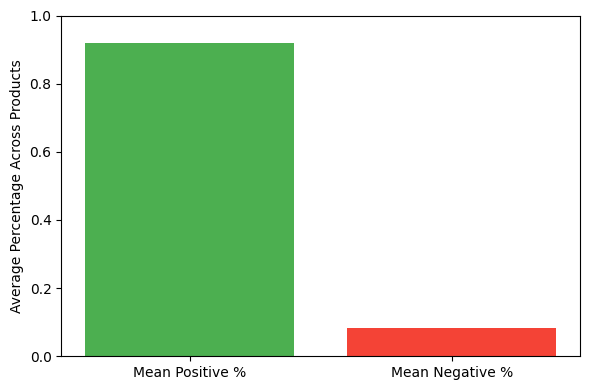

In [59]:
stats = pd.read_csv("product_sentiment_stats.csv")
mean_pos = stats['pos_pct'].mean()
mean_neg = stats['neg_pct'].mean()

plt.figure(figsize=(6, 4))
plt.bar(['Mean Positive %', 'Mean Negative %'], [mean_pos, mean_neg], color=['#4CAF50', '#F44336'])
plt.ylabel("Average Percentage Across Products")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


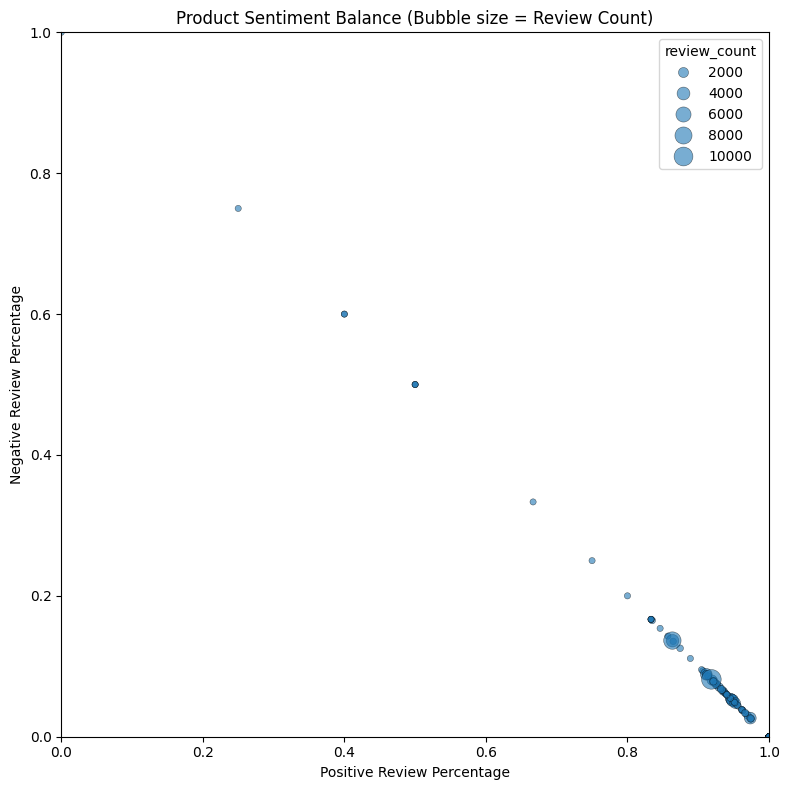

In [60]:
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=stats,
    x="pos_pct",
    y="neg_pct",
    size="review_count",
    sizes=(20, 200),
    alpha=0.6,
    edgecolor="k"
)
plt.title("Product Sentiment Balance (Bubble size = Review Count)")
plt.xlabel("Positive Review Percentage")
plt.ylabel("Negative Review Percentage")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()


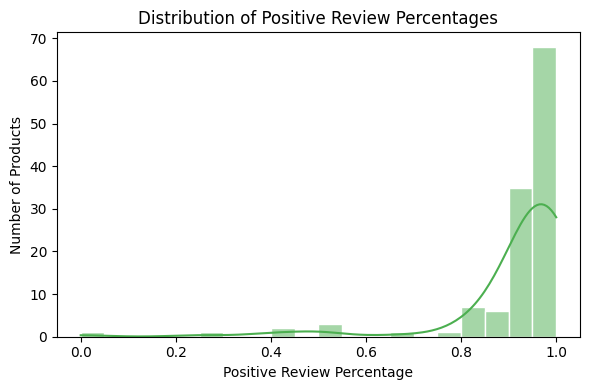

In [61]:
plt.figure(figsize=(6, 4))
sns.histplot(stats['pos_pct'], bins=20, kde=True, color="#4CAF50", edgecolor="white")
plt.title("Distribution of Positive Review Percentages")
plt.xlabel("Positive Review Percentage")
plt.ylabel("Number of Products")
plt.tight_layout()


<ipython-input-62-1267421246>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-62-1267421246>:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


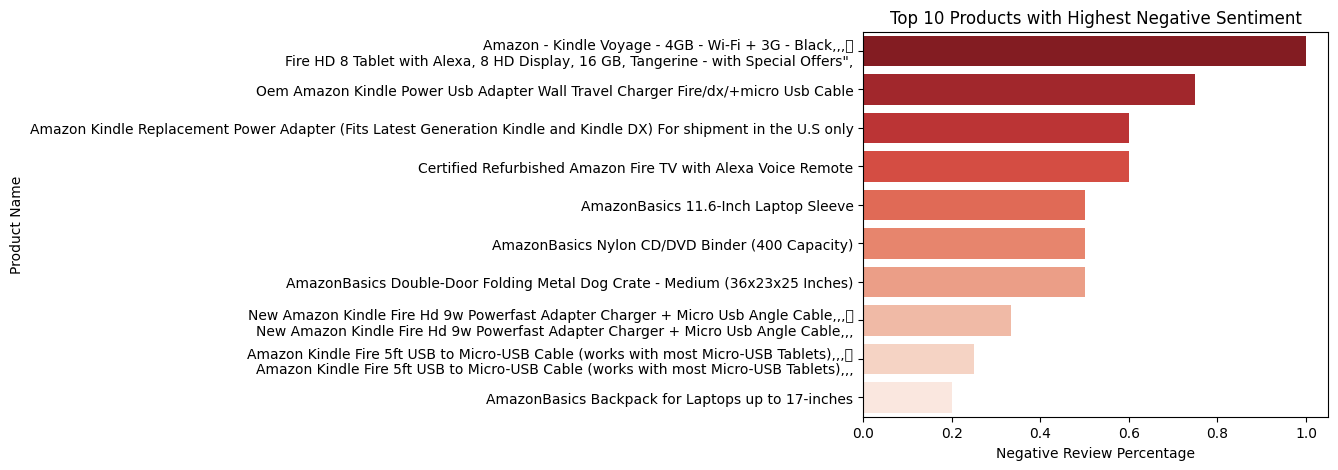

In [62]:
top_neg = stats.sort_values('neg_pct', ascending=False).head(10)

plt.figure(figsize=(6, 5))
sns.barplot(
    data=top_neg,
    x='neg_pct',
    y='name',
    palette='Reds_r'
)
plt.title("Top 10 Products with Highest Negative Sentiment")
plt.xlabel("Negative Review Percentage")
plt.ylabel("Product Name")
plt.tight_layout()


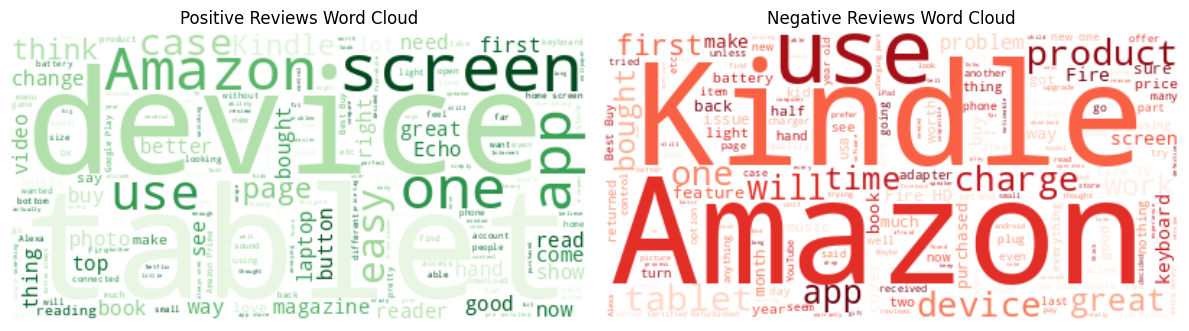

In [63]:
from wordcloud import WordCloud

top_reviews = pd.read_csv("top_reviews_per_product.csv")
text_pos = " ".join(top_reviews["reviews.text_pos"].astype(str).values)
text_neg = " ".join(top_reviews["reviews.text_neg"].astype(str).values)

wc_pos = WordCloud(width=400, height=200, background_color="white", colormap="Greens").generate(text_pos)
wc_neg = WordCloud(width=400, height=200, background_color="white", colormap="Reds").generate(text_neg)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.tight_layout()


In [64]:
%%shell
jupyter nbconvert --to html /content/sentiment_analysis_my.ipynb

[NbConvertApp] Converting notebook /content/sentiment_analysis_my.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1106909 bytes to /content/sentiment_analysis_my.html
